In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

# Load CSV files with ';' as the delimiter
df1 = pd.read_csv('/content/sample_data/load_profile_t3.csv', delimiter=';')
df2 = pd.read_csv('/content/sample_data/load_profile_heat_python.csv', delimiter=';')
df3 = pd.read_csv('/content/sample_data/sun_python_norm.csv', delimiter=';')
df4 = pd.read_csv('/content/sample_data/wind_python_norm.csv', delimiter=';')

# Rename columns
df1.rename(columns={'Hours': 'hour', 'load_kw': 'load_kw'}, inplace=True)
df2.rename(columns={'hour': 'hour', 'h_load_kw': 'h_load_kw'}, inplace=True)
df3.rename(columns={'hour': 'hour', 'sun_norm': 'sun_capacity_factor'}, inplace=True)
df4.rename(columns={'hour': 'hour', 'wind_norm': 'wind_capacity_factor'}, inplace=True)

# Increase solar and wind capacity factors by 25%, capped at 1.0
df3['sun_capacity_factor'] = np.minimum(df3['sun_capacity_factor'] * 1.0, 1.0)
df4['wind_capacity_factor'] = np.minimum(df4['wind_capacity_factor'] * 1.0, 1.0)

# Merge dataframes
df_combined = df1.merge(df2, on='hour').merge(df3, on='hour').merge(df4, on='hour')
df_combined.fillna(0, inplace=True)

# Constants
biogas_efficiency = 0.8
discharge_efficiency = 0.9
emissions = {"biogas": 55.82}
min_soc = 0.2
battery_dis_eff = 0.95
battery_cha_eff = 0.9


results = []
grid_steps = 30
weight_range = np.linspace(0, 1, grid_steps)

for w_lcoe in tqdm(weight_range, desc="LCOE Weight Loop"):
    for w_unmet in weight_range:
        w_co2 = 1 - w_lcoe - w_unmet
        if w_co2 > 0:
            continue

#results = []

#w_lcoe = 0.72
#w_unmet = 0.28
#w_co2 = 0.0

        def objective(capacities):
            solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

            capex = {
                "solar": 815 * solar_capacity,
                "wind": 5675 * wind_capacity,
                "battery": 475 * battery_capacity,
                "biogas": 1000 * biogas_capacity,
                "converter": 750 * converter_capacity,
            }

            total_kWh_biogas = 0
            total_met_elec = 0
            total_met_heat = 0
            total_unmet_elec = 0
            total_unmet_heat = 0
            battery_soc = battery_capacity * 0.5

            for _, row in df_combined.iterrows():
                elec_demand = row["load_kw"]
                heat_demand = row["h_load_kw"]
                solar_elec = solar_capacity * row["sun_capacity_factor"]
                wind_elec = wind_capacity * row["wind_capacity_factor"]

                # Heat from biogas
                biogas_heat = min(heat_demand, biogas_capacity * biogas_efficiency)
                unmet_heat = max(0, heat_demand - biogas_heat)

                # Battery logic
                available_elec = solar_elec + wind_elec
                battery_charge = max(0, available_elec - elec_demand) if battery_soc < 1.0 else 0
                battery_discharge = min(elec_demand - available_elec, battery_soc * battery_capacity * discharge_efficiency) if battery_soc > min_soc else 0
                battery_soc += battery_charge * battery_cha_eff - battery_discharge / discharge_efficiency
                battery_soc = max(min_soc, min(1, battery_soc))

                elec_met = solar_elec + wind_elec + battery_discharge
                unmet_elec = max(0, elec_demand - elec_met)

                # Biogas for remaining unmet electricity
                biogas_elec = min(unmet_elec, max(0, (biogas_capacity * biogas_efficiency) - biogas_heat))
                biogas_kWh = biogas_heat + biogas_elec

                total_kWh_biogas += biogas_kWh
                total_met_elec += min(elec_demand, elec_met + biogas_elec)
                total_met_heat += biogas_heat
                total_unmet_elec += max(0, elec_demand - (elec_met + biogas_elec))
                total_unmet_heat += unmet_heat

            # OPEX & financials
            opex = {
                "solar": 17 * solar_capacity * 10,
                "battery": 0.025 * capex["battery"] * 10,
                "biogasf": 1.0*0.035 * capex['biogas'] * 10,
                "biogasv": (1.0*4.51 * total_kWh_biogas / 1000) * 10,
            }

            salvage = {key: 0.3 * value for key, value in capex.items()}
            total_opex = sum(opex.values())
            total_capex = sum(capex.values())
            total_salvage = sum(salvage.values())

            total_energy_production = total_met_elec + total_met_heat
            discount_rate = 0.05
            years_to_discount = 10
            disc_to_use = (1 + discount_rate) ** years_to_discount
            LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / (total_energy_production + 1e-6)

            total_GJ_biogas = (total_kWh_biogas * 0.0036) / biogas_efficiency
            total_CO2_biogas_tons = (total_GJ_biogas * emissions["biogas"]) / 1000

            total_demand = df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()
            demand_met = total_met_elec + total_met_heat
            total_demand_not_met = (total_demand - demand_met) / total_demand

            return (
                w_lcoe * LCOE_system +
                w_unmet * total_demand_not_met +
                w_co2 * total_CO2_biogas_tons
            )

        def demand_constraint(capacities):
            solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

            total_electricity_demand = df_combined['load_kw'].sum()
            total_heat_demand = df_combined['h_load_kw'].sum()
            total_electricity_met = 0
            total_heat_met = 0

            for _, row in df_combined.iterrows():
                available_power = (
                    solar_capacity * row["sun_capacity_factor"] +
                    wind_capacity * row["wind_capacity_factor"] +
                    max(0, (biogas_capacity * biogas_efficiency - row["h_load_kw"])) +
                    (battery_capacity * discharge_efficiency if battery_capacity > 0 else 0)
                )
                available_heat = biogas_capacity * biogas_efficiency
                total_electricity_met += min(available_power, row['load_kw'])
                total_heat_met += min(available_heat, row['h_load_kw'])

            elec_ratio = total_electricity_met / total_electricity_demand if total_electricity_demand > 0 else 0
            heat_ratio = total_heat_met / total_heat_demand if total_heat_demand > 0 else 0

            return min(elec_ratio - 0.97, heat_ratio - 0.97)

        bounds = [(0, 500)] * 5
        constraints = [{"type": "ineq", "fun": demand_constraint}]
        initial_guess = [100, 100, 100, 100, 100]

        result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

        # ... The rest of your result processing, plotting, and CSV export follows as-is ...


        if result.success:
            optimized_capacities = result.x

            solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = optimized_capacities
            battery_soc = battery_capacity * 0.5  # Assume 50% initial charge
            total_battery_discharge= 0
            total_kWh_biogas = 0
            total_electricity_met = 0
            total_heat_met = 0
            total_GJ_biogas = 0
            total_unmet_elec= 0
            total_unmet_heat = 0
            estimated_biogas_kWh = 0
            total_emission_elec = 0
            total_emission_heat = 0

            for _, row in df_combined.iterrows():
                elec_demand = row["load_kw"]
                heat_demand = row["h_load_kw"]
                solar_elec = solar_capacity * row["sun_capacity_factor"]
                wind_elec = wind_capacity * row["wind_capacity_factor"]

                available_elec = solar_elec + wind_elec
                battery_charge = max(0, available_elec - elec_demand) if battery_soc < 1.0 else 0
                battery_discharge = min(elec_demand - available_elec, battery_soc * battery_capacity * discharge_efficiency) if battery_soc > min_soc else 0
                battery_soc += battery_charge * battery_cha_eff - battery_discharge / discharge_efficiency
                battery_soc = max(min_soc, min(1, battery_soc))
                total_battery_discharge += battery_discharge

                elec_met = solar_elec + wind_elec + battery_discharge
                unmet_elec = max(0, elec_demand - elec_met)

                biogas_heat = min(heat_demand, biogas_capacity * biogas_efficiency)
                unmet_heat = max(0, heat_demand - biogas_heat)

                biogas_elec = min(unmet_elec, max(0, (biogas_capacity * biogas_efficiency) - heat_demand))
                biogas_GJ_elec = biogas_elec * 0.0036 / biogas_efficiency
                emission_elec= (biogas_GJ_elec * emissions["biogas"]) / 1000

                biogas_GJ_heat = biogas_heat * 0.0036 / biogas_efficiency
                emission_heat= (biogas_GJ_heat * emissions["biogas"]) / 1000

                biogas_kWh = biogas_heat + biogas_elec
                total_emission_elec += emission_elec
                total_emission_heat += emission_heat
                total_kWh_biogas += biogas_kWh
                total_GJ_biogas += (biogas_kWh * 0.0036) / biogas_efficiency

                total_electricity_met += min(elec_demand, elec_met + biogas_elec)
                total_heat_met += biogas_heat

            total_CO2_biogas_tons = total_GJ_biogas * emissions["biogas"] / 1000
            total_demand_not_met = (
                (df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()) -
                (total_electricity_met + total_heat_met)
            ) / (df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum())

            capex = {
                "solar": 815 * optimized_capacities[0],
                "wind": 5675 * optimized_capacities[1],
                "battery": 475 * optimized_capacities[2],
                "biogas": 1000 * optimized_capacities[3],
                "converter": 750 * optimized_capacities[4],
            }

            opex = {
                "solar": 17 * optimized_capacities[0] * 10,
                "battery": 0.025 * capex["battery"] * 10,
                "biogasf": 1.0* 0.035 * capex['biogas'] * 10,
                "biogasv": (1.0* 4.51 * total_kWh_biogas / 1000) * 10,
            }

            total_opex = sum(opex.values())
            total_capex = sum(capex.values())
            total_salvage = sum({key: 0.3 * value for key, value in capex.items()}.values())
            total_energy_production = df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()
            discount_rate = 0.05
            years_to_discount = 10
            disc_to_use = (1 + discount_rate) ** years_to_discount
            LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / total_energy_production
            LCOE_electricity= (total_opex - opex['biogasf'] - opex['biogasv'] + total_capex - capex['biogas']- total_salvage) / (disc_to_use*total_electricity_met)
            total_GJ_biogas = (total_kWh_biogas * 0.0036) / biogas_efficiency
            total_CO2_biogas_tons = (total_GJ_biogas * emissions["biogas"]) / 1000


            # Unmet demand (final)
            total_electricity_met = 0
            total_heat_met = 0
            for _, row in df_combined.iterrows():
                available_power = (
                    optimized_capacities[0] * row["sun_capacity_factor"] +
                    optimized_capacities[1] * row["wind_capacity_factor"] +
                    (optimized_capacities[3] * biogas_efficiency- row["h_load_kw"]) +
                    (optimized_capacities[2] * discharge_efficiency if optimized_capacities[2] > 0 else 0)
                )
                available_heat = optimized_capacities[3] * biogas_efficiency
                total_electricity_met += min(available_power, row['load_kw'])
                total_heat_met += min(available_heat, row['h_load_kw'])


            unmet_electricity_total = max(0, df_combined['load_kw'].sum() - total_electricity_met)
            unmet_heat_total = max(0, df_combined['h_load_kw'].sum() - total_heat_met)

            total_demand_not_met = (unmet_electricity_total + unmet_heat_total) / ((df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()))

            renewable_production = (
                  optimized_capacities[0] * df_combined['sun_capacity_factor'].sum() +
                  optimized_capacities[1] * df_combined['wind_capacity_factor'].sum()
              )
            specific_biogas_elec= (total_emission_elec / total_electricity_met)*1000 # kgrams/kwh
            specific_biogas_heat= (total_emission_heat / total_heat_met) *1000 # kgrams/kwh
            biomass_needed= (total_GJ_biogas*1000 /22)/(1.15*0.5)


    results.append({
        "w_LCOE": w_lcoe,
        "w_Unmet": w_unmet,
        "w_CO2": w_co2,
        "LCOE": LCOE_system,
        "LCOE_electricity": LCOE_electricity,
        "Unmet": total_demand_not_met * 100,  # percent
        "Unmet_electricity": unmet_electricity_total,
        "Unmet_heat": unmet_heat_total,
        "CO2": total_CO2_biogas_tons,
        "solar_capacity": optimized_capacities[0],
        "wind_capacity": optimized_capacities[1],
        "battery_capacity": optimized_capacities[2],
        "biogas_capacity": optimized_capacities[3],
        "converter_capacity": optimized_capacities[4],
        "renewable_production": renewable_production,
        "specific_biogas_elec": specific_biogas_elec,
        "specific_biogas_heat": specific_biogas_heat,
        "total_battery_discharge": total_battery_discharge,
        "biomass_needed": biomass_needed,
        "biogas_kWh": total_kWh_biogas,
        "total_electricity_met": total_electricity_met,
        "total_heat_met": total_heat_met,
        "total_salvage": total_salvage,
    })

# === 3D Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = [r['Unmet'] for r in results]
ys = [r['LCOE'] for r in results]
zs = [r['CO2'] for r in results]

ax.scatter(xs, ys, zs, c='teal')
ax.set_xlabel('Unmet Demand (%)')
ax.set_ylabel('LCOE (USD/kWh)')
ax.set_zlabel('CO₂ Emissions (tons)')
ax.set_title('3D Trade-Off: Unmet Demand vs LCOE vs CO₂')
plt.tight_layout()
plt.show()

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Save to CSV
df_results.to_csv('optimization_results_t32019pareto.csv', index=False)

print(df_results)

FileNotFoundError: [Errno 2] No such file or directory: '/content/sample_data/load_profile_t3.csv'

In [ ]:
# Print first 5 and last 5 solar capacity factors
print("Solar capacity factors (first 5):")
print(df3['sun_capacity_factor'].head())

print("\nSolar capacity factors (last 5):")
print(df3['sun_capacity_factor'].tail())

# Print first 5 and last 5 wind capacity factors
print("\nWind capacity factors (first 5):")
print(df4['wind_capacity_factor'].head())

print("\nWind capacity factors (last 5):")
print(df4['wind_capacity_factor'].tail())


   w_LCOE  w_Unmet  w_CO2      LCOE  LCOE_electricity     Unmet  \
0    0.72     0.28    0.0  0.227254          0.172726  0.603415

   Unmet_electricity   Unmet_heat         CO2  solar_capacity  wind_capacity  \
0           88.20764  6477.702853  254.460767       71.379878   5.875510e-13

   battery_capacity  biogas_capacity  converter_capacity  \
0         88.587029       208.330565           86.719476

   renewable_production  specific_biogas_elec  specific_biogas_heat  \
0         123596.256975              0.133237               0.25119

   total_battery_discharge
0            -84006.862495

Solar capacity factors (first 5):
0    0.000
1    0.086
2    0.368
3    0.588
4    0.716
Name: sun_capacity_factor, dtype: float64

Solar capacity factors (last 5):
8758    0.0
8759    0.0
8760    NaN
8761    NaN
8762    NaN
Name: sun_capacity_factor, dtype: float64

Wind capacity factors (first 5):
0    0.000
1    0.000
2    0.000
3    0.000
4    0.022
Name: wind_capacity_factor, dtype: float64

Wind capacity factors (last 5):
8758    0.002
8759    0.002
8760    0.000
8761    0.000
8762    0.000
Name: wind_capacity_factor, dtype: float64


In [ ]:
print(emission_elec)
print(biogas_GJ_elec)
print(unmet_elec)
print(total_unmet_elec)
print(df_combined['h_load_kw'].sum())
print(df_results['biogas_capacity'].iloc[0] * biogas_efficiency * len(df_combined))
import pandas as pd
df = pd.read_csv('/content/optimization_results_t32019_shock.csv')
print(df[['unmet_electricity_total', 'unmet_heat_total']])





0.0
0.0
2.524
0
942079.6826000016
1021441.3514098305


FileNotFoundError: [Errno 2] No such file or directory: '/content/optimization_results_t32019_shock.csv'

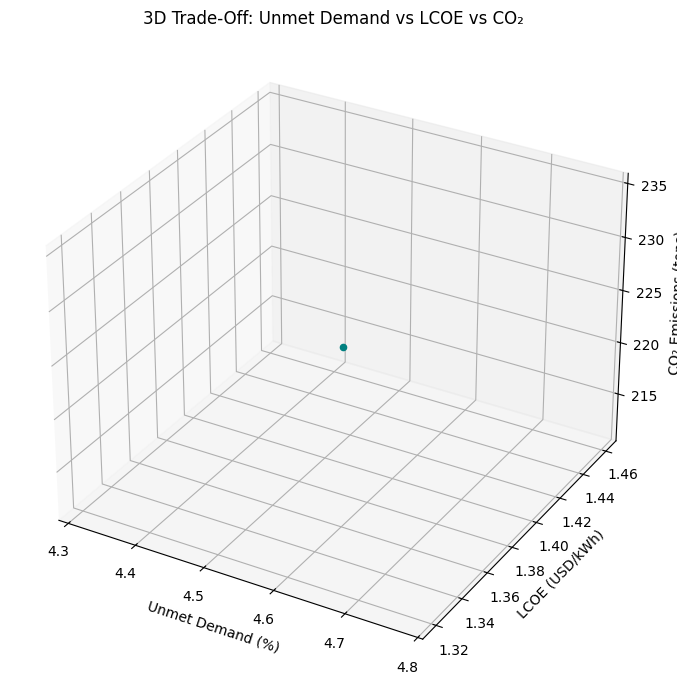

   w_LCOE  w_Unmet  w_CO2      LCOE  LCOE_electricity     Unmet         CO2  \
0    0.72     0.28    0.0  1.389483         15.925359  4.546317  223.148276   

   solar_capacity  wind_capacity  battery_capacity  biogas_capacity  \
0      297.505035          500.0         85.422512       169.154389   

   converter_capacity  Renewable_Production  
0        3.252483e-14          1.377582e+06  


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

# Load CSV files with ';' as the delimiter
df1 = pd.read_csv('/content/sample_data/load_profile_t3.csv', delimiter=';')  # Load profile (demand data)
df2 = pd.read_csv('/content/sample_data/load_profile_heat_python.csv', delimiter=';')  # Heat demand data
df3 = pd.read_csv('/content/sample_data/sun_python_norm.csv', delimiter=';')  # Solar data (normalized)
df4 = pd.read_csv('/content/sample_data/wind_python_norm.csv', delimiter=';')  # Wind data (normalized)

# Rename and merge
df1.rename(columns={'Hours': 'hour', 'load_kw': 'load_kw'}, inplace=True)
df2.rename(columns={'hour': 'hour', 'h_load_kw': 'h_load_kw'}, inplace=True)
df3.rename(columns={'hour': 'hour', 'sun_norm': 'sun_capacity_factor'}, inplace=True)
df4.rename(columns={'hour': 'hour', 'wind_norm': 'wind_capacity_factor'}, inplace=True)
df_combined = df1.merge(df2, on='hour').merge(df3, on='hour').merge(df4, on='hour')
df_combined.fillna(0, inplace=True)

# Adjust capacity factors
df_combined['sun_capacity_factor'] *= 1.23
df_combined['wind_capacity_factor'] *= 1.33
df_combined['sun_capacity_factor'] = df_combined['sun_capacity_factor'].clip(upper=1.0)
df_combined['wind_capacity_factor'] = df_combined['wind_capacity_factor'].clip(upper=1.0)

# Constants
biogas_efficiency = 0.8
discharge_efficiency = 0.9
emissions = {"biogas": 55.82}
min_soc = 0.2
battery_dis_eff = 0.95
battery_cha_eff = 0.9

results = []

w_lcoe = 0.72
w_unmet = 0.28
w_co2 = 0.0

def objective(capacities):
    solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

    # CAPEX
    capex = {
        "solar": 815 * solar_capacity,
        "wind": 5675 * wind_capacity,
        "battery": 475 * battery_capacity,
        "biogas": 1000 * biogas_capacity,
        "converter": 750 * converter_capacity,
    }

    # System
    total_kWh_biogas = 0
    battery_soc = battery_capacity * 0.5  # Assume 50% initial charge
    total_unmet_elec = 0
    total_met_elec= 0
    total_met_heat = 0
    total_unmet_heat = 0
    for _, row in df_combined.iterrows():
        elec_demand = row["load_kw"]
        heat_demand = row["h_load_kw"]
        solar_elec = solar_capacity * row["sun_capacity_factor"]
        wind_elec = wind_capacity * row["wind_capacity_factor"]
        battery_charge = max(0, (solar_elec + wind_elec) - elec_demand) if battery_soc < 1.0 else 0
        battery_discharge = min(elec_demand - (solar_elec + wind_elec), battery_soc * battery_capacity * discharge_efficiency) if battery_soc > min_soc else 0
        total_unmet_elec += max(0, elec_demand - (solar_elec + wind_elec + battery_discharge))
        total_unmet_heat += max(0, heat_demand - (biogas_capacity * biogas_efficiency))
        total_met_elec += min(solar_elec + wind_elec + battery_discharge, elec_demand)
        total_met_heat += min(0, heat_demand, (biogas_capacity * biogas_efficiency))
        total_kWh_biogas += total_unmet_elec + total_met_heat

        # Update battery state of charge (SOC)
        battery_soc += battery_charge * battery_cha_eff - battery_discharge / discharge_efficiency
        battery_soc = max(min_soc, min(1, battery_soc))  # Keep SOC between min_soc and 1

    opex = {
        "solar": 17 * solar_capacity * 10,
        "battery": 0.025 * capex["battery"] * 10,
        "biogasf": 0.035 * capex['biogas'] * 10,
        "biogasv": (4.51 * total_kWh_biogas / 1000) * 10,
    }

    salvage = {key: 0.3 * value for key, value in capex.items()}
    total_opex = sum(opex.values())
    total_capex = sum(capex.values())
    total_salvage = sum(salvage.values())

    #LCOE
    total_energy_production = total_met_heat + total_met_elec
    discount_rate = 0.05
    years_to_discount = 10
    disc_to_use = (1 + discount_rate) ** years_to_discount
    LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / total_energy_production

    # Unmet demand
    Unmet_electricity= total_unmet_elec
    Unmet_heat= total_unmet_heat
    total_demand_not_met = (Unmet_electricity + Unmet_heat) / (df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum())


    # CO2 Calculation (Updated)
    total_GJ_biogas = 0
    for _, row in df_combined.iterrows():
        # Track the unmet electricity demand
        unmet_elec = max(0, row['load_kw'] - (solar_capacity * row["sun_capacity_factor"] + wind_capacity * row["wind_capacity_factor"] + battery_discharge))

        # Track the unmet heat demand
        unmet_heat = max(0, row['h_load_kw'] - (biogas_capacity * biogas_efficiency))

        # Calculate the energy in GJ that would come from biogas
        total_GJ_biogas += (unmet_elec + min(available_heat, row['h_load_kw'])) * 0.0036 / biogas_efficiency  # Convert from kWh to GJ

    # CO2 emissions from biogas
    total_CO2_biogas_tons = total_GJ_biogas * emissions["biogas"] / 1000  # CO2 in tons

    return (
        w_lcoe * LCOE_system +
        w_unmet * total_demand_not_met +
        w_co2 * total_CO2_biogas_tons
    )

def demand_constraint(capacities):
    solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

    total_electricity_demand = df_combined['load_kw'].sum()
    total_heat_demand = df_combined['h_load_kw'].sum()
    total_electricity_met = 0
    total_heat_met = 0

    for _, row in df_combined.iterrows():
        available_power = (
            solar_capacity * row["sun_capacity_factor"] +
            wind_capacity * row["wind_capacity_factor"] +
            (biogas_capacity * biogas_efficiency - row['h_load_kw']) +
            (battery_capacity * discharge_efficiency if battery_capacity > 0 else 0)
        )
        available_heat = biogas_capacity * biogas_efficiency
        total_electricity_met += min(available_power, row['load_kw'])
        total_heat_met += min(available_heat, row['h_load_kw'])

    elec_ratio = total_electricity_met / total_electricity_demand if total_electricity_demand > 0 else 0
    heat_ratio = total_heat_met / total_heat_demand if total_heat_demand > 0 else 0

    return min(elec_ratio - 0.95, heat_ratio - 0.95)

bounds = [(0, 500)] * 5
constraints = [{"type": "ineq", "fun": demand_constraint}]
initial_guess = [100, 100, 100, 100, 100]

result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

if result.success:
    optimized_capacities = result.x

    # Recalculate estimated biogas use with optimized capacities
    estimated_biogas_kWh = 0
    available_heat = optimized_capacities[3] * biogas_efficiency
    for _, row in df_combined.iterrows():
        elec_demand = row["load_kw"]
        heat_demand = row["h_load_kw"]
        solar_elec = optimized_capacities[0] * row["sun_capacity_factor"]
        wind_elec = optimized_capacities[1] * row["wind_capacity_factor"]
        unmet_elec = max(0, elec_demand - (solar_elec + wind_elec))
        unmet_heat = max(0, heat_demand - (optimized_capacities[3] * biogas_efficiency))
        estimated_biogas_kWh += min(unmet_elec, available_heat- row['h_load_kw']) + min(available_heat, row['h_load_kw'])

    capex = {
        "solar": 815 * optimized_capacities[0],
        "wind": 5675 * optimized_capacities[1],
        "battery": 475 * optimized_capacities[2],
        "biogas": 1000 * optimized_capacities[3],
        "converter": 750 * optimized_capacities[4],
    }

    opex = {
        "solar": 17 * optimized_capacities[0] * 10,
        "battery": 0.025 * capex["battery"] * 10,
        "biogasf": 0.035 * capex['biogas'] * 10,
        "biogasv": (4.51 * estimated_biogas_kWh / 1000) * 10,
    }

    total_opex = sum(opex.values())
    total_capex = sum(capex.values())
    total_salvage = sum({key: 0.3 * value for key, value in capex.items()}.values())
    total_energy_production = df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()
    discount_rate = 0.05
    years_to_discount = 10
    disc_to_use = (1 + discount_rate) ** years_to_discount
    LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / total_energy_production
    LCOE_electricity= (total_opex - opex['biogasf'] - opex['biogasv'] + total_capex - capex['biogas']) / (total_energy_production- estimated_biogas_kWh)
    total_GJ_biogas = (estimated_biogas_kWh * 0.0036) / biogas_efficiency
    total_CO2_biogas_tons = (total_GJ_biogas * emissions["biogas"]) / 1000

    # Unmet demand (final)
    total_electricity_met = 0
    total_heat_met = 0
    for _, row in df_combined.iterrows():
        available_power = (
            optimized_capacities[0] * row["sun_capacity_factor"] +
            optimized_capacities[1] * row["wind_capacity_factor"] +
            (optimized_capacities[3] * biogas_efficiency- row["h_load_kw"]) +
            (optimized_capacities[2] * discharge_efficiency if optimized_capacities[2] > 0 else 0)
        )
        available_heat = optimized_capacities[3] * biogas_efficiency
        total_electricity_met += min(available_power, row['load_kw'])
        total_heat_met += min(available_heat, row['h_load_kw'])


    unmet_electricity_total = max(0, df_combined['load_kw'].sum() - total_electricity_met)
    unmet_heat_total = max(0, df_combined['h_load_kw'].sum() - total_heat_met)

    total_demand_not_met = (unmet_electricity_total + unmet_heat_total) / ((df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()))

    renewable_production = (
        optimized_capacities[0] * df_combined['sun_capacity_factor'].sum() +
        optimized_capacities[1] * df_combined['wind_capacity_factor'].sum()
    )

    results.append({
        "w_LCOE": w_lcoe,
        "w_Unmet": w_unmet,
        "w_CO2": w_co2,
        "LCOE": LCOE_system,
        "LCOE_electricity": LCOE_electricity,
        "Unmet": total_demand_not_met * 100,  # percent
        "CO2": total_CO2_biogas_tons,
        "solar_capacity": optimized_capacities[0],
        "wind_capacity": optimized_capacities[1],
        "battery_capacity": optimized_capacities[2],
        "biogas_capacity": optimized_capacities[3],
        "converter_capacity": optimized_capacities[4],
        "Renewable_Production": renewable_production,
    })

# === 3D Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = [r['Unmet'] for r in results]
ys = [r['LCOE'] for r in results]
zs = [r['CO2'] for r in results]

ax.scatter(xs, ys, zs, c='teal')
ax.set_xlabel('Unmet Demand (%)')
ax.set_ylabel('LCOE (USD/kWh)')
ax.set_zlabel('CO₂ Emissions (tons)')
ax.set_title('3D Trade-Off: Unmet Demand vs LCOE vs CO₂')
plt.tight_layout()
plt.show()

# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Save to CSV
df_results.to_csv('optimization_results_t32019_shock.csv', index=False)

print(df_results)


In [ ]:
print(total_unmet_heat)

0


Optimization Successful. Capacities: [7.92168893e+01 2.13162821e-14 8.89402317e+01 1.69154389e+02
 8.71327313e+01]
   solar_capacity  wind_capacity  battery_capacity  biogas_capacity  \
0       79.216889   2.131628e-14         88.940232       169.154389   

   converter_capacity  renewable_production  
0           87.132731         137166.261953  


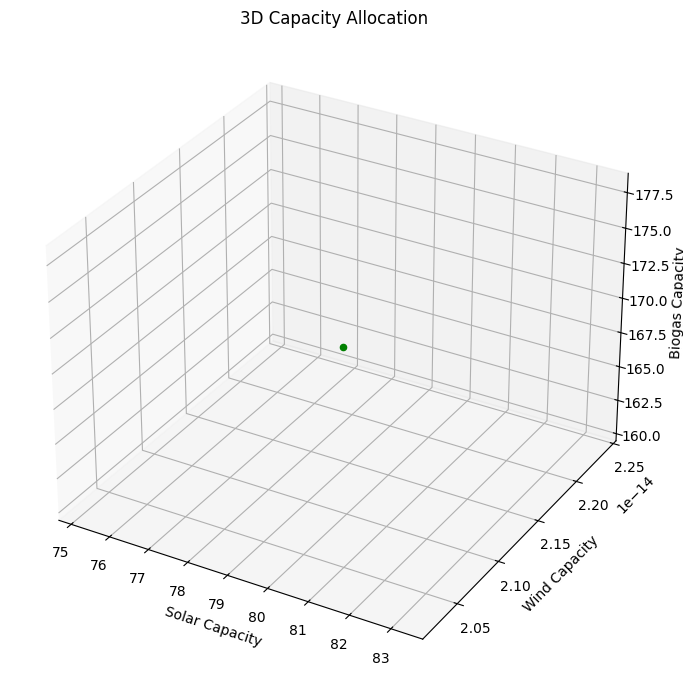

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

# Load CSV files
df1 = pd.read_csv('/content/sample_data/load_profile_t3.csv', delimiter=';')
df2 = pd.read_csv('/content/sample_data/load_profile_heat_python.csv', delimiter=';')
df3 = pd.read_csv('/content/sample_data/sun_python_norm.csv', delimiter=';')
df4 = pd.read_csv('/content/sample_data/wind_python_norm.csv', delimiter=';')

# Rename columns
df1.rename(columns={'Hours': 'hour', 'load_kw': 'load_kw'}, inplace=True)
df2.rename(columns={'hour': 'hour', 'h_load_kw': 'h_load_kw'}, inplace=True)
df3.rename(columns={'hour': 'hour', 'sun_norm': 'sun_capacity_factor'}, inplace=True)
df4.rename(columns={'hour': 'hour', 'wind_norm': 'wind_capacity_factor'}, inplace=True)

# Merge data
df_combined = df1.merge(df2, on='hour').merge(df3, on='hour').merge(df4, on='hour')
df_combined.fillna(0, inplace=True)

# Ensure capacity factors are within bounds
df_combined['sun_capacity_factor'] = df_combined['sun_capacity_factor'].clip(upper=1.0)
df_combined['wind_capacity_factor'] = df_combined['wind_capacity_factor'].clip(upper=1.0)

# Constants
biogas_efficiency = 0.8
discharge_efficiency = 0.9
emissions = {"biogas": 55.82}  # kg CO₂ per GJ
min_soc = 0.2
battery_dis_eff = 0.95
battery_cha_eff = 0.9

results = []
w_lcoe = 0.78
w_unmet = 0.22
w_co2 = 0.0

def objective(capacities):
    solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

    capex = {
        "solar": 815 * solar_capacity,
        "wind": 5675 * wind_capacity,
        "battery": 475 * battery_capacity,
        "biogas": 1000 * biogas_capacity,
        "converter": 750 * converter_capacity,
    }

    battery_soc = battery_capacity * 0.5
    total_kWh_biogas = 0

    for _, row in df_combined.iterrows():
        elec_demand = row["load_kw"]
        heat_demand = row["h_load_kw"]
        solar_elec = solar_capacity * row["sun_capacity_factor"]
        wind_elec = wind_capacity * row["wind_capacity_factor"]

        battery_discharge = battery_capacity * discharge_efficiency if battery_soc > min_soc else 0
        supply = solar_elec + wind_elec + battery_discharge
        unmet_elec = max(0, elec_demand - supply)
        met_heat = min(heat_demand, biogas_capacity * biogas_efficiency)
        total_kWh_biogas += unmet_elec + met_heat

        battery_charge = max(0, supply - elec_demand) if battery_soc < 1 else 0
        battery_soc += battery_charge * battery_cha_eff - battery_discharge / discharge_efficiency
        battery_soc = max(min_soc, min(1, battery_soc))

    opex = {
        "solar": 17 * solar_capacity * 10,
        "battery": 0.025 * capex["battery"] * 10,
        "biogasf": 0.035 * capex['biogas'] * 10,
        "biogasv": (4.51 * total_kWh_biogas / 1000) * 10,
    }

    salvage = {key: 0.3 * value for key, value in capex.items()}
    total_opex = sum(opex.values())
    total_capex = sum(capex.values())
    total_salvage = sum(salvage.values())

    total_energy_production = df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum()
    discount_rate = 0.05
    disc_factor = (1 + discount_rate) ** 10
    LCOE_system = ((total_opex + total_capex - total_salvage) / disc_factor) / total_energy_production

    # Unmet demand
    total_electricity_demand = df_combined['load_kw'].sum()
    total_heat_demand = df_combined['h_load_kw'].sum()
    total_electricity_met = 0
    total_heat_met = 0

    for _, row in df_combined.iterrows():
        available_power = (
            solar_capacity * row["sun_capacity_factor"] +
            wind_capacity * row["wind_capacity_factor"] +
            max(0, (biogas_capacity * biogas_efficiency - row['h_load_kw'])) +
            (battery_capacity * discharge_efficiency)
        )
        total_electricity_met += min(available_power, row['load_kw'])
        total_heat_met += min(biogas_capacity * biogas_efficiency, row['h_load_kw'])

    unmet_total = (total_electricity_demand - total_electricity_met +
                   total_heat_demand - total_heat_met)
    total_demand_not_met = max(0, unmet_total) / (total_electricity_demand + total_heat_demand)

    # CO2 emissions
    total_GJ_biogas = total_kWh_biogas * 0.0036 / biogas_efficiency
    total_CO2_biogas_tons = total_GJ_biogas * emissions["biogas"] / 1000

    return (
        w_lcoe * LCOE_system +
        w_unmet * total_demand_not_met +
        w_co2 * total_CO2_biogas_tons
    )

def demand_constraint(capacities):
    solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

    total_electricity_demand = df_combined['load_kw'].sum()
    total_heat_demand = df_combined['h_load_kw'].sum()
    total_electricity_met = 0
    total_heat_met = 0

    for _, row in df_combined.iterrows():
        available_power = (
            solar_capacity * row["sun_capacity_factor"] +
            wind_capacity * row["wind_capacity_factor"] +
            max(0, biogas_capacity * biogas_efficiency - row['h_load_kw']) +
            (battery_capacity * discharge_efficiency)
        )
        available_heat = biogas_capacity * biogas_efficiency
        total_electricity_met += min(available_power, row['load_kw'])
        total_heat_met += min(available_heat, row['h_load_kw'])

    elec_ratio = total_electricity_met / total_electricity_demand if total_electricity_demand > 0 else 0
    heat_ratio = total_heat_met / total_heat_demand if total_heat_demand > 0 else 0

    return min(elec_ratio - 0.95, heat_ratio - 0.95)

# Optimization
bounds = [(0, 500)] * 5
constraints = [{"type": "ineq", "fun": demand_constraint}]
initial_guess = [100, 100, 100, 100, 100]
result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

# Collect results if successful
if result.success:
    optimized_capacities = result.x
    print("Optimization Successful. Capacities:", optimized_capacities)

    renewable_production = (
        optimized_capacities[0] * df_combined['sun_capacity_factor'].sum() +
        optimized_capacities[1] * df_combined['wind_capacity_factor'].sum()
    )

    results.append({
        "solar_capacity": optimized_capacities[0],
        "wind_capacity": optimized_capacities[1],
        "battery_capacity": optimized_capacities[2],
        "biogas_capacity": optimized_capacities[3],
        "converter_capacity": optimized_capacities[4],
        "renewable_production": renewable_production,
    })

    df_results = pd.DataFrame(results)
    df_results.to_csv('optimization_results_cleaned.csv', index=False)
    print(df_results)

    # Plot results
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_results['solar_capacity'], df_results['wind_capacity'], df_results['biogas_capacity'], c='green')
    ax.set_xlabel('Solar Capacity')
    ax.set_ylabel('Wind Capacity')
    ax.set_zlabel('Biogas Capacity')
    ax.set_title('3D Capacity Allocation')
    plt.tight_layout()
    plt.show()


Vectorized

In [ ]:
import numpy as np

step_count = 10  # e.g., steps of 0.25 → 0 to 1 in 5 values
combinations = []

# Generate integer partitions of step_count: a + b + c = step_count
for a in range(step_count + 1):
    for b in range(step_count + 1 - a):
        c = step_count - a - b
        # Normalize to sum to 1.0
        w_lcoe = a / step_count
        w_unmet = b / step_count
        w_co2 = c / step_count
        combinations.append((w_lcoe, w_unmet, w_co2))

# Print results
for w_lcoe, w_unmet, w_co2 in combinations:
    print(f"w_lcoe: {w_lcoe:.2f}, w_unmet: {w_unmet:.2f}, w_co2: {w_co2:.2f}")


w_lcoe: 0.00, w_unmet: 0.00, w_co2: 1.00
w_lcoe: 0.00, w_unmet: 0.10, w_co2: 0.90
w_lcoe: 0.00, w_unmet: 0.20, w_co2: 0.80
w_lcoe: 0.00, w_unmet: 0.30, w_co2: 0.70
w_lcoe: 0.00, w_unmet: 0.40, w_co2: 0.60
w_lcoe: 0.00, w_unmet: 0.50, w_co2: 0.50
w_lcoe: 0.00, w_unmet: 0.60, w_co2: 0.40
w_lcoe: 0.00, w_unmet: 0.70, w_co2: 0.30
w_lcoe: 0.00, w_unmet: 0.80, w_co2: 0.20
w_lcoe: 0.00, w_unmet: 0.90, w_co2: 0.10
w_lcoe: 0.00, w_unmet: 1.00, w_co2: 0.00
w_lcoe: 0.10, w_unmet: 0.00, w_co2: 0.90
w_lcoe: 0.10, w_unmet: 0.10, w_co2: 0.80
w_lcoe: 0.10, w_unmet: 0.20, w_co2: 0.70
w_lcoe: 0.10, w_unmet: 0.30, w_co2: 0.60
w_lcoe: 0.10, w_unmet: 0.40, w_co2: 0.50
w_lcoe: 0.10, w_unmet: 0.50, w_co2: 0.40
w_lcoe: 0.10, w_unmet: 0.60, w_co2: 0.30
w_lcoe: 0.10, w_unmet: 0.70, w_co2: 0.20
w_lcoe: 0.10, w_unmet: 0.80, w_co2: 0.10
w_lcoe: 0.10, w_unmet: 0.90, w_co2: 0.00
w_lcoe: 0.20, w_unmet: 0.00, w_co2: 0.80
w_lcoe: 0.20, w_unmet: 0.10, w_co2: 0.70
w_lcoe: 0.20, w_unmet: 0.20, w_co2: 0.60
w_lcoe: 0.20, w_

LCOE Weight Loop: 100%|██████████| 10/10 [02:47<00:00, 16.79s/it]


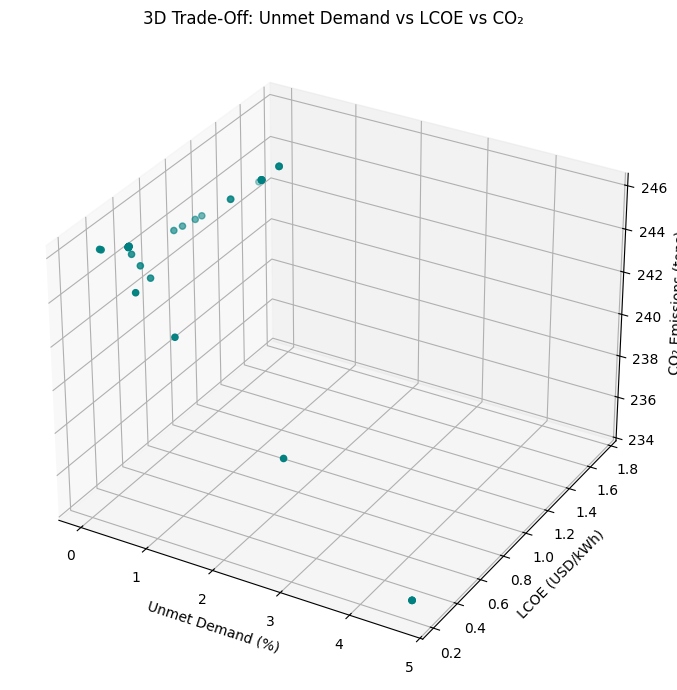

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

# Load CSVs
df1 = pd.read_csv('/content/sample_data/load_profile_t2.csv', delimiter=';')
df2 = pd.read_csv('/content/sample_data/load_profile_heat_python.csv', delimiter=';')
df3 = pd.read_csv('/content/sample_data/sun_python_norm.csv', delimiter=';')
df4 = pd.read_csv('/content/sample_data/wind_python_norm.csv', delimiter=';')

# Rename columns
df1.rename(columns={'Hours': 'hour', 'load_kw': 'load_kw'}, inplace=True)
df2.rename(columns={'hour': 'hour', 'h_load_kw': 'h_load_kw'}, inplace=True)
df3.rename(columns={'hour': 'hour', 'sun_norm': 'sun_capacity_factor'}, inplace=True)
df4.rename(columns={'hour': 'hour', 'wind_norm': 'wind_capacity_factor'}, inplace=True)

# Merge data
df_combined = df1.merge(df2, on='hour').merge(df3, on='hour').merge(df4, on='hour')
df_combined.fillna(0, inplace=True)

# Constants
biogas_efficiency = 0.8
discharge_efficiency = 0.9
emissions = {"biogas": 55.82}  # kg CO₂/GJ
min_soc = 0.2
battery_dis_eff = 0.95
battery_cha_eff = 0.9

results = []
grid_steps = 10
weight_range = np.linspace(0, 1, grid_steps)

# Precompute for vectorized sections
load_kw = df_combined['load_kw'].values
h_load_kw = df_combined['h_load_kw'].values
sun_cf = df_combined['sun_capacity_factor'].values
wind_cf = df_combined['wind_capacity_factor'].values

for w_lcoe in tqdm(weight_range, desc="LCOE Weight Loop"):
    for w_unmet in weight_range:
        w_co2 = 1 - w_lcoe - w_unmet
        if w_co2 < 0:
            continue

        def objective(capacities):
            solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

            # CAPEX
            capex = {
                "solar": 815 * solar_capacity,
                "wind": 5675 * wind_capacity,
                "battery": 475 * battery_capacity,
                "biogas": 1000 * biogas_capacity,
                "converter": 750 * converter_capacity,
            }

            # Vectorized solar and wind electricity generation
            solar_gen = solar_capacity * sun_cf
            wind_gen = wind_capacity * wind_cf
            total_gen = solar_gen + wind_gen

            # Biogas and battery state handled in loop due to SOC dependency
            total_kWh_biogas = 0
            battery_soc = battery_capacity * 0.5
            for i in range(len(load_kw)):
                elec_demand = load_kw[i]
                heat_demand = h_load_kw[i]
                solar_elec = solar_gen[i]
                wind_elec = wind_gen[i]

                battery_discharge = battery_capacity * discharge_efficiency if battery_soc > min_soc else 0
                unmet_elec = max(0, elec_demand - (solar_elec + wind_elec + battery_discharge))
                unmet_heat = max(0, heat_demand - (biogas_capacity * biogas_efficiency))
                met_heat= min(biogas_capacity * biogas_efficiency, heat_demand)
                total_kWh_biogas += unmet_elec + unmet_heat

                battery_charge = min(0, elec_demand - (solar_elec + wind_elec)) if battery_soc < min_soc else 0
                battery_soc += battery_charge * battery_cha_eff - battery_discharge / discharge_efficiency
                battery_soc = max(min_soc, min(1, battery_soc))

            opex = {
                "solar": 17 * solar_capacity * 10,
                "battery": 0.025 * capex["battery"] * 10,
                "biogasf": 0.035 * capex['biogas'] * 10,
                "biogasv": (4.51 * total_kWh_biogas / 1000) * 10,
            }

            salvage = {key: 0.3 * value for key, value in capex.items()}
            total_opex = sum(opex.values())
            total_capex = sum(capex.values())
            total_salvage = sum(salvage.values())

            total_energy_production = load_kw.sum() + h_load_kw.sum()
            discount_rate = 0.05
            years_to_discount = 10
            disc_to_use = (1 + discount_rate) ** years_to_discount
            LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / total_energy_production

            # Unmet demand (vectorized available power)
            elec_available = solar_gen + wind_gen + (biogas_capacity * biogas_efficiency - h_load_kw) + (battery_capacity * discharge_efficiency)
            heat_available = biogas_capacity * biogas_efficiency

            elec_met = np.minimum(elec_available, load_kw).sum()
            heat_met = np.minimum(heat_available, h_load_kw).sum()

            unmet_ratio = (load_kw.sum() + h_load_kw.sum() - (elec_met + heat_met)) / (load_kw.sum() + h_load_kw.sum())

            # CO2 emissions from biogas
            biogas_used_GJ = (total_kWh_biogas * 0.0036) / biogas_efficiency
            total_CO2_biogas_tons = biogas_used_GJ * emissions["biogas"] / 1000

            return (
                w_lcoe * LCOE_system +
                w_unmet * unmet_ratio +
                w_co2 * total_CO2_biogas_tons
            )

        def demand_constraint(capacities):
            solar_capacity, wind_capacity, battery_capacity, biogas_capacity, converter_capacity = capacities

            solar_gen = solar_capacity * sun_cf
            wind_gen = wind_capacity * wind_cf
            elec_available = solar_gen + wind_gen + (biogas_capacity * biogas_efficiency - h_load_kw) + (battery_capacity * discharge_efficiency)
            heat_available = biogas_capacity * biogas_efficiency

            elec_met = np.minimum(elec_available, load_kw).sum()
            heat_met = np.minimum(heat_available, h_load_kw).sum()

            elec_ratio = elec_met / load_kw.sum() if load_kw.sum() > 0 else 0
            heat_ratio = heat_met / h_load_kw.sum() if h_load_kw.sum() > 0 else 0

            return min(elec_ratio - 0.95, heat_ratio - 0.95)

        bounds = [(0, 500)] * 5
        constraints = [{"type": "ineq", "fun": demand_constraint}]
        initial_guess = [100, 100, 100, 100, 100]

        result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

        if result.success:
            opt = result.x
            solar_gen = opt[0] * sun_cf
            wind_gen = opt[1] * wind_cf
            total_gen = solar_gen + wind_gen

            # Estimate biogas again
            biogas_used_kWh = 0
            for i in range(len(load_kw)):
                elec_demand = load_kw[i]
                heat_demand = h_load_kw[i]
                unmet_elec = max(0, elec_demand - (solar_gen[i] + wind_gen[i]))
                heat_met = min(heat_demand, opt[3] * biogas_efficiency)
                biogas_used_kWh += unmet_elec + heat_met

            total_GJ_biogas = (biogas_used_kWh * 0.0036) / biogas_efficiency
            total_CO2_biogas_tons = total_GJ_biogas * emissions["biogas"] / 1000

            capex = {
                "solar": 815 * opt[0],
                "wind": 5675 * opt[1],
                "battery": 475 * opt[2],
                "biogas": 1000 * opt[3],
                "converter": 750 * opt[4],
            }

            opex = {
                "solar": 17 * opt[0] * 10,
                "battery": 0.025 * capex["battery"] * 10,
                "biogasf": 0.035 * capex['biogas'] * 10,
                "biogasv": (4.51 * biogas_used_kWh / 1000) * 10,
            }

            total_opex = sum(opex.values())
            total_capex = sum(capex.values())
            total_salvage = sum({key: 0.3 * value for key, value in capex.items()}.values())
            discount_rate = 0.05
            years_to_discount = 10
            disc_to_use = (1 + discount_rate) ** years_to_discount
            LCOE_system = ((total_opex + total_capex - total_salvage) / disc_to_use) / (load_kw.sum() + h_load_kw.sum())

            elec_available = solar_gen + wind_gen + (opt[3] * biogas_efficiency - h_load_kw) + (opt[2] * discharge_efficiency)
            heat_available = opt[3] * biogas_efficiency

            elec_met = np.minimum(elec_available, load_kw).sum()
            heat_met = np.minimum(heat_available, h_load_kw).sum()

            unmet_total_ratio = (load_kw.sum() + h_load_kw.sum() - (elec_met + heat_met)) / (load_kw.sum() + h_load_kw.sum())

            results.append({
                "w_LCOE": w_lcoe,
                "w_Unmet": w_unmet,
                "w_CO2": w_co2,
                "LCOE": LCOE_system,
                "Unmet": unmet_total_ratio * 100,
                "CO2": total_CO2_biogas_tons,
                "solar_capacity": opt[0],
                "wind_capacity": opt[1],
                "battery_capacity": opt[2],
                "biogas_capacity": opt[3],
                "converter_capacity": opt[4]
            })

# === 3D Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = [r['Unmet'] for r in results]
ys = [r['LCOE'] for r in results]
zs = [r['CO2'] for r in results]

ax.scatter(xs, ys, zs, c='teal')
ax.set_xlabel('Unmet Demand (%)')
ax.set_ylabel('LCOE (USD/kWh)')
ax.set_zlabel('CO₂ Emissions (tons)')
ax.set_title('3D Trade-Off: Unmet Demand vs LCOE vs CO₂')
plt.tight_layout()
plt.show()


In [ ]:
print(f"Number of results: {len(results)}")



Number of results: 210


In [ ]:
import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)
print(unmet_electricity_total)
print(unmet_heat_total)
print(df_combined['load_kw'].sum() + df_combined['h_load_kw'].sum())
print(total_demand_not_met)

# === 3D Plot ===
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

xs = [r['Unmet'] for r in results]
ys = [r['LCOE'] for r in results]
zs = [r['CO2'] for r in results]

ax.scatter(xs, ys, zs, c='teal')
ax.set_xlabel('Unmet Demand (%)')
ax.set_ylabel('LCOE (USD/kWh)')
ax.set_zlabel('CO₂ Emissions (tons)')
ax.set_title('3D Trade-Off: Unmet Demand vs LCOE vs CO₂')
plt.tight_layout()
plt.show()


       w_LCOE   w_Unmet         w_CO2      LCOE     Unmet        CO2  \
0    0.000000  0.000000  1.000000e+00  1.709139  0.000000   6.673571   
1    0.000000  0.052632  9.473684e-01  1.711699  0.000000   6.673053   
2    0.000000  0.105263  8.947368e-01  1.710228  0.000000   6.673338   
3    0.000000  0.157895  8.421053e-01  1.711604  0.000000   6.673089   
4    0.000000  0.210526  7.894737e-01  1.711705  0.000000   6.673032   
..        ...       ...           ...       ...       ...        ...   
205  0.894737  0.052632  5.263158e-02  0.252253  0.041674   9.713178   
206  0.894737  0.105263  1.110223e-16  0.198936  4.696489  21.686911   
207  0.947368  0.000000  5.263158e-02  0.249537  0.045108   9.761638   
208  0.947368  0.052632  5.551115e-17  0.198928  4.696571  21.686911   
209  1.000000  0.000000  0.000000e+00  0.198922  4.696646  21.686908   

     solar_capacity  wind_capacity  battery_capacity  biogas_capacity  \
0        277.919320   5.000000e+02        100.000000       496

NameError: name 'unmet_electricity_total' is not defined